In [1]:
import serial
import serial.tools.list_ports as list_ports
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import time
%matplotlib notebook

ports = list(list_ports.grep("USB"))

com_dict = {port.description: port.device for port in ports }

port_list = widgets.Dropdown(
    options=com_dict,
    description='Port:',
)
display(port_list)

connect_button = widgets.Button(description="Connect")
disconnect_button = widgets.Button(description="Disconnect")

display(connect_button)
display(disconnect_button)

def on_connect_clicked(b):
    global ser
    ser = serial.serial_for_url("hwgrep://{}".format(port_list.value),timeout=2)
    if ser.is_open is True:
        ser.write('c')
        time.sleep(1)
        for line in ser:
            print line
connect_button.on_click(on_connect_clicked)
def on_disconnect_clicked(b):
    global ser
    if ser.is_open is True:
        ser.write('d')
        time.sleep(1)
        for line in ser:
            print line
        ser.close()
disconnect_button.on_click(on_disconnect_clicked)

In [4]:
import matplotlib.pyplot as plt

start_adc_button = widgets.Button(description="Start ADC")
stop_adc_button = widgets.Button(description="Stop ADC")
measure_button = widgets.Button(description="Measure")

rate = widgets.Dropdown(
    options=[1,2,5,10,15,30,60,120],
    description='Sampling Rate:',
    disabled=False
)

seconds_entry = widgets.IntText(
    value=10,
    description='Time (s):',
    disabled=False
)
freq = widgets.Dropdown(
    options=["50 Hz","60 Hz"],
    value="60 Hz",
    description='Line Frequency:',
    disabled=False
)

measurement_mode = widgets.Select(
    options=['Single', 'Continuous'],
    value='Single',
    description='Measurement Mode:',
    disabled=False
)

display(start_adc_button)

def on_start_adc_clicked(b):
    ser.write('v'); #begin adc
    time.sleep(1)
    for line in ser:
        print line
    ser.write('b'); #begin adc
    time.sleep(1)
    for line in ser:
        print line
    ser.write('s'); #get status of the adc
    time.sleep(1)
    for line in ser.readlines():
        line
    display(stop_adc_button)
    display(freq)
    display(measurement_mode)
    display(rate)
    display(seconds_entry)
    display(measure_button)  
start_adc_button.on_click(on_start_adc_clicked)

def on_stop_adc_clicked(b):
    ser.write('e'); #begin adc
    time.sleep(1)
    for line in ser:
        print line
stop_adc_button.on_click(on_stop_adc_clicked)

def on_measure_clicked(b):  
    global ADC_Out 
    ADC_Out = []
    global Time_Out
    Time_Out=[]

    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    
    #Set Line Frequency
    ser.write('f')
    if freq == "50 Hz":
        ser.write('1')
    else:
        ser.write('2')
    time.sleep(1)   
    if measurement_mode.value == 'Single':
        mes_mod = 'o'
    else:
        mes_mod = 'm'
    ser.write(mes_mod)
    time.sleep(1)
    ser.write(str(chr(rate.value)))
    ser.write(str(seconds_entry.value))
    ser.write("/") 
    counter = 0
    for line in ser.readlines():
#         print line
        try:
            mtime,_,adc = line.partition(':')
            if (adc != ''):
                Time_Out.append(int(mtime))
                ADC_Out.append(int(adc))
                #ax.plot(Time_Out,ADC_Out)
                #fig.canvas.draw()
                    
        except ValueError:
            continue
        
measure_button.on_click(on_measure_clicked)
# a = ser.read_all()
# for line in a.split('\r\n'):
#     print line

In [7]:
df_adc=pd.DataFrame(ADC_Out,columns=["ADC"])
df_time=pd.DataFrame(Time_Out,columns=["Time(ms)"])
frames=[df_time,df_adc]
df_data = pd.concat(frames, axis=1)
df_data["Time(s)"] = df_data["Time(ms)"]/1000
df_data["IVC Out"] = (3.0/ 16777215.0) * df_data["ADC"] #24-bit A/D : (2^24 - 1) = 1677215 steps
df_data["PMT Out"] = df_data["IVC Out"] /30000
#df_data.groupby('IVC Out').mean()
df_data

,Time(ms),ADC,Time(s),IVC Out,PMT Out
0,0,0,0.000,0.0,0.0
1,998,0,0.998,0.0,0.0
2,1995,0,1.995,0.0,0.0
3,2992,0,2.992,0.0,0.0
4,3989,0,3.989,0.0,0.0
5,4986,0,4.986,0.0,0.0
6,5983,0,5.983,0.0,0.0
7,6980,0,6.980,0.0,0.0
8,7977,0,7.977,0.0,0.0
9,8974,0,8.974,0.0,0.0


<IPython.core.display.Javascript object>


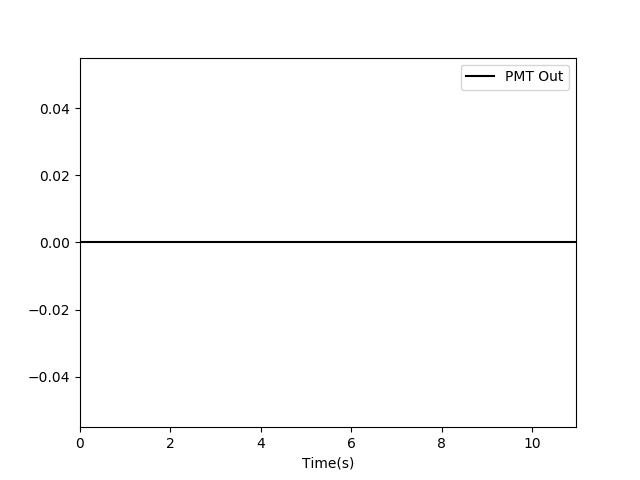

In [8]:
df_data[["Time(s)","PMT Out"]].plot(x= "Time(s)", color='black')

In [ ]:
ser.write('s'); #get status of the adc
time.sleep(1)
for line in ser:
    print line